In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from scipy import stats
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
import gc
import pickle
import tqdm
from string import punctuation
import re
import datetime
import seaborn

pd.set_option('display.max_columns', 99999)



In [2]:
plays_df = pd.read_csv(r'C:\Users\Evan\Desktop\Capstone_Project\plays_df.csv', index_col='Unnamed: 0')

In [3]:
object_cols = []

for c in plays_df.columns:
    if plays_df[c].dtype == 'object':
        print(c)
        object_cols.append(c)

PossessionTeam
OffensePersonnel
DefensePersonnel
TimeHandoff
TimeSnap
HomeTeamAbbr
VisitorTeamAbbr
Stadium
Location
Position_1
Position_2
Position_3
Position_4
Position_5
Position_6
Position_7
Position_8
Position_9
Position_10
Position_11
Position_12
Position_13
Position_14
Position_15
Position_16
Position_17
Position_18
Position_19
Position_20
Position_21
Position_22
RunningAngle
TrenchBattle
Space
DistanceCat
LineOfScrimmage


In [4]:
plays_df = pd.concat([plays_df, pd.get_dummies(plays_df['PossessionTeam'], prefix='Possession')], axis=1)

In [5]:
for c in plays_df.columns:
    if c == "DefensePersonnel":
        arr = [[int(s[0]) for s in t.split(", ")] for t in plays_df["DefensePersonnel"]]
        plays_df["DL"] = np.array([a[0] for a in arr])
        plays_df["LB"] = np.array([a[1] for a in arr])
        plays_df["DB"] = np.array([a[2] for a in arr])

    if c == 'OffensePersonnel':
        arr = [[int(s[0]) for s in t.split(", ")] for t in plays_df["OffensePersonnel"]]
        plays_df['WR'] = np.array([a[-1] for a in arr])
        plays_df["TE"] = np.array([a[-2] for a in arr])
        plays_df["RB"] = np.array([a[-3] for a in arr])
        plays_df["OL"] = np.array([10 - (a[-1] + a[-2] + a[-3]) for a in arr])

In [6]:
plays_df = pd.concat([plays_df, pd.get_dummies(plays_df['Position_22'], prefix='Runner')], axis=1)

In [7]:


plays_df = plays_df.drop(object_cols, axis=1)

In [8]:
plays_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31007 entries, 0 to 31006
Columns: 411 entries, GameId to Runner_WR
dtypes: bool(2), float64(224), int32(7), int64(136), uint8(42)
memory usage: 87.5 MB


In [9]:
y = np.array(plays_df['Yards'])
X = plays_df.drop(['Yards'], axis=1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
scaler = preprocessing.StandardScaler()
scaler.fit(y_train.reshape(-1, 1))
y_train = scaler.transform(y_train.reshape(-1,1)).flatten()

C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [12]:
scaler = preprocessing.StandardScaler()
scaler.fit(y_test.reshape(-1, 1))
y_test = scaler.transform(y_test.reshape(-1,1)).flatten()

C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\Evan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [16]:
leaf_space = [2, 3, 4] + list(range(5, 100, 5))
val_scores = []
params = []


for leaves in leaf_space:
    folds = 10
    seed = 222
    kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
    y_valid_pred = np.zeros(X_train.shape[0])
    models = []
    # Do k-fold cross validation
    for tr_idx, val_idx in kf.split(X_train, y_train):
        tr_x, tr_y = X_train.iloc[tr_idx,:], y_train[tr_idx]
        vl_x, vl_y = X_train.iloc[val_idx,:], y_train[val_idx]

        # print(len(tr_x),len(vl_x))
        tr_data = lgb.Dataset(tr_x, label=tr_y)
        vl_data = lgb.Dataset(vl_x, label=vl_y)  
        clf = lgb.LGBMRegressor(n_estimators=200,learning_rate=0.01, num_leaves=leaves)
        clf.fit(tr_x, tr_y,
            eval_set=[(vl_x, vl_y)],
            early_stopping_rounds=20,
            verbose=False)
        # Save the validation predicted value of the best iteration
        y_valid_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
        models.append(clf)
        
        
    # Calculate the validation score
    y_pred = np.zeros((len(y_train),199))
    y_ans = np.zeros((len(y_train),199))

    for i,p in enumerate(np.round(scaler.inverse_transform(y_valid_pred))):
        p+=99
        for j in range(199):
            if j>=p+10:
                y_pred[i][j]=1.0
            elif j>=p-10:
                y_pred[i][j]=(j+10-p)*0.05

    for i,p in enumerate(scaler.inverse_transform(y_train)):
        p+=99
        for j in range(199):
            if j>=p:
                y_ans[i][j]=1.0
    
    print('Leaves : {}'.format(leaves))
    print("validation score:",np.sum(np.power(y_pred-y_ans,2))/(199*(len(y_train))))
    val_scores.append(np.sum(np.power(y_pred-y_ans,2))/(199*(len(y_train))))            
    params.append(leaves)
        
print('Best Param : {}'.format(params[val_scores.index(min(val_scores))])) 

Leaves : 2
validation score: 0.014751620428285338
Leaves : 3
validation score: 0.014632581370873721
Leaves : 4
validation score: 0.014577518716339185
Leaves : 5
validation score: 0.01455679425144265
Leaves : 10
validation score: 0.014519234957289988
Leaves : 15
validation score: 0.01450699881183787
Leaves : 20
validation score: 0.014502298835439055
Leaves : 25
validation score: 0.014498854887215753
Leaves : 30
validation score: 0.014500637636884273
Leaves : 35
validation score: 0.014489880363316282
Leaves : 40
validation score: 0.014494296720449641
Leaves : 45
validation score: 0.01449520835380287
Leaves : 50
validation score: 0.014497254464217893
Leaves : 55
validation score: 0.014498409199798631
Leaves : 60
validation score: 0.014499523418341462
Leaves : 65
validation score: 0.014499097989443288
Leaves : 70
validation score: 0.014493972584146305
Leaves : 75
validation score: 0.014493445862653314
Leaves : 80
validation score: 0.014489900621835241
Leaves : 85
validation score: 0.014495

In [17]:
data = list(zip(params, val_scores))
scores_df = pd.DataFrame(data, columns=['params', 'val_scores'])



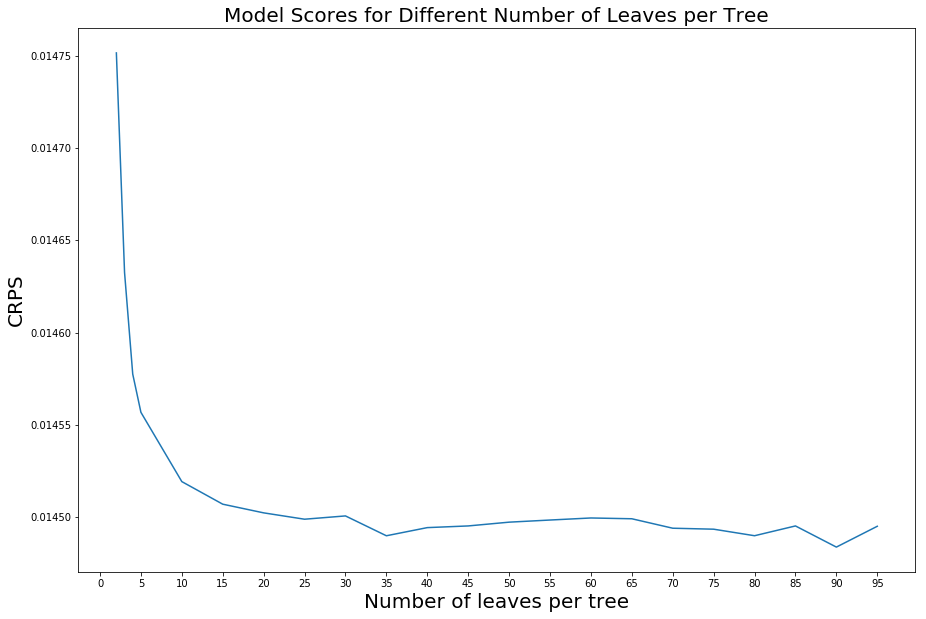

In [27]:
plt.rcParams["figure.figsize"] = (15,10)
plt.plot('params', 'val_scores', data=scores_df)
plt.xlabel('Number of leaves per tree', size=20)
plt.ylabel('CRPS', size=20)
plt.xticks(list(range(0,100,5)))
plt.title('Model Scores for Different Number of Leaves per Tree', size=20)
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\LeavesTuning.png')
plt.show()


In [28]:
LR_space = [0.0001, 0.001, 0.01, 0.1]
estimator_space = [200, 300, 400, 500]
params = []
scores = []

for LR in LR_space:
    for estimator in estimator_space:
        folds = 5
        seed = 222
        kf = KFold(n_splits = folds, shuffle = True, random_state=seed)
        y_valid_pred = np.zeros(X_train.shape[0])
        models = []
        # Do k-fold cross validation
        for tr_idx, val_idx in kf.split(X_train, y_train):
            tr_x, tr_y = X_train.iloc[tr_idx,:], y_train[tr_idx]
            vl_x, vl_y = X_train.iloc[val_idx,:], y_train[val_idx]

            # print(len(tr_x),len(vl_x))
            tr_data = lgb.Dataset(tr_x, label=tr_y)
            vl_data = lgb.Dataset(vl_x, label=vl_y)  
            clf = lgb.LGBMRegressor(n_estimators=estimator,learning_rate=LR, num_leaves=90)
            clf.fit(tr_x, tr_y,
                eval_set=[(vl_x, vl_y)],
                early_stopping_rounds=20,
                verbose=False)
            # Save the predicted value of the best iteration
            y_valid_pred[val_idx] += clf.predict(vl_x, num_iteration=clf.best_iteration_)
            models.append(clf)

        # Fit the model to the test data
        y_hat = clf.predict(X_test, num_iteration=clf.best_iteration_, raw_score=True)

        # Calculate the test score
        y_pred = np.zeros((len(plays_df),199))
        y_ans = np.zeros((len(plays_df),199))

        for i,p in enumerate(np.round(scaler.inverse_transform(y_valid_pred))):
            p+=99
            for j in range(199):
                if j>=p+10:
                    y_pred[i][j]=1.0
                elif j>=p-10:
                    y_pred[i][j]=(j+10-p)*0.05

        for i,p in enumerate(scaler.inverse_transform(y_train)):
            p+=99
            for j in range(199):
                if j>=p:
                    y_ans[i][j]=1.0


        print('Trees : {}'.format(estimator))
        print('Learning Rate: {}'.format(LR))
        print("validation score:",np.sum(np.power(y_pred-y_ans,2))/(199*(len(y_train))))
        scores.append(np.sum(np.power(y_pred-y_ans,2))/(199*(len(y_train))))
        params.append((estimator, LR))
        
print('Best Param : {}'.format(params[scores.index(min(scores))])) 

Trees : 200
Learning Rate: 0.0001
validation score: 0.014837678616829364
Trees : 300
Learning Rate: 0.0001
validation score: 0.014835997159755632
Trees : 400
Learning Rate: 0.0001
validation score: 0.014834781648618015
Trees : 500
Learning Rate: 0.0001
validation score: 0.014834396736757759
Trees : 200
Learning Rate: 0.001
validation score: 0.014775019017684672
Trees : 300
Learning Rate: 0.001
validation score: 0.014701075423479025
Trees : 400
Learning Rate: 0.001
validation score: 0.014667648867194275
Trees : 500
Learning Rate: 0.001
validation score: 0.014643946400010535
Trees : 200
Learning Rate: 0.01
validation score: 0.014517512983178337
Trees : 300
Learning Rate: 0.01
validation score: 0.014514656532004915
Trees : 400
Learning Rate: 0.01
validation score: 0.014512914299374319
Trees : 500
Learning Rate: 0.01
validation score: 0.014512914299374319
Trees : 200
Learning Rate: 0.1
validation score: 0.014593178551495632
Trees : 300
Learning Rate: 0.1
validation score: 0.014593178551495

In [29]:
# Fit a model with the best hyperparameters
LR = 0.01
leaves = 90
estimators = 400

model = lgb.LGBMRegressor(n_estimators=estimators, learning_rate=LR, num_leaves=leaves, importance_type='gain')

model.fit(X_train, y_train)

y_hat = model.predict(X_test, raw_score=True)

In [30]:
# Evaluate the model using continuous ranked probability score (CRPS)
y_pred = np.zeros((len(X_test),199))
y_ans = np.zeros((len(X_test),199))

for i,p in enumerate(np.round(scaler.inverse_transform(y_hat))):
    p+=99
    for j in range(199):
        if j>=p+10:
            y_pred[i][j]=1.0
        elif j>=p-10:
            y_pred[i][j]=(j+10-p)*0.05

for i,p in enumerate(scaler.inverse_transform(y_test)):
    p+=99
    for j in range(199):
        if j>=p:
            y_ans[i][j]=1.0

print("test score:",np.sum(np.power(y_pred-y_ans,2))/(199*(len(X_test))))

test score: 0.014782757709865025


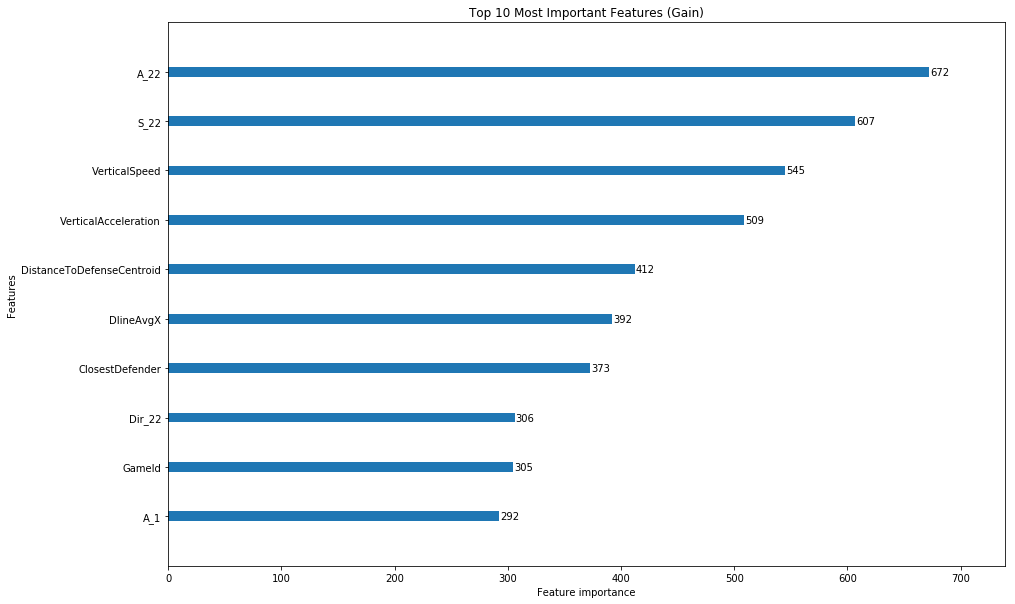

In [36]:
plt.rcParams["figure.figsize"] = (15,10)
lgb.plot_importance(model, max_num_features = 10, importance_type='split')
plt.title('Top 10 Most Important Features (Gain)')
plt.grid(False)
plt.savefig(r'C:\Users\Evan\Desktop\Capstone_Project\Images\FeatureImportance.png', bbox_inches='tight')
plt.show()